<a href="https://www.kaggle.com/code/willyclarke/segnet-v2?scriptVersionId=136094853" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [12]:
import os
import numpy as np
import cv2
import torchvision.models.segmentation
import torch
import torchvision.transforms as tf
import torch.optim as optim
import shutil
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
from torch.autograd import Variable

In [13]:
'''
Lifted from https://towardsdatascience.com/train-neural-net-for-semantic-segmentation-with-pytorch-in-50-lines-of-code-830c71a6544f
'''
# Parameters
WINDOW_SIZE = (256, 256) # Patch size
STRIDE = 32 # Stride for testing
IN_CHANNELS = 3 # Number of input channels (e.g. RGB)
FOLDER = "/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data"
BATCH_SIZE = 3 # Number of samples in a mini-batch
DROP = 0.5 #  Probability between  0 AND 1

LABELS = ["Healthy", "Disease"] # Label names
N_CLASSES = len(LABELS) # Number of classes
WEIGHTS = torch.ones(N_CLASSES) # Weights for class balancing
CACHE = True # Store the dataset in-memory

Learning_Rate = 1e-5  # step size of the gradient descent during the training.
width = height = 256  # image width and height
batchSize = 3  # number of images that will be used for each iteration of the training.
Weight_Decay = 0.000001  # Increasing can help prevent overfitting
# Create a list of all the images for training
TrainFolder = "/kaggle/input/leaf-disease-segmentation-dataset/data/data"
ListImages = os.listdir(os.path.join(TrainFolder, "images"))

# define a set of transformations that will be performed on the image using the TorchVision transform module:
transformImg = tf.Compose([tf.ToPILImage(),  # Convert to PIL format
                           tf.Resize((height, width)),  # Standardise image size
                           tf.ToTensor(),  # Convert to Pytorch format
                           tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
# normalize the intensity of the pixels in the image by subtracting the Mean and dividing
# by the standard deviation of pixels intensity

# Annotation map
transformAnn = tf.Compose([tf.ToPILImage(),
                           tf.Resize((height, width)),
                           tf.ToTensor()])


# create a function that will allow us to load a random image and the corresponding annotation map for training
def ReadRandomImage():
    idx = np.random.randint(0, len(ListImages))  # Pick random image
    Img = cv2.imread(os.path.join(TrainFolder, "images", ListImages[idx]))
    lesion = cv2.imread(os.path.join(TrainFolder, "masks", ListImages[idx].replace("jpg", "png")), 0)

    AnnMap = np.zeros(Img.shape[0:2], np.float32)  # Segmentation map
    if lesion is not None: AnnMap[lesion > 0] = 1
    Img = transformImg(Img)  # converts to Pytorch Format as defined earlier
    AnnMap = transformAnn(AnnMap)
    return Img, AnnMap


# To train, load to images in a 4D
def LoadBatch():  # Load batch of images
    images = torch.zeros([batchSize, 3, height, width])  # [batchSize, channels, height, width]
    ann = torch.zeros([batchSize, height, width])
    # load set of images and annotation to the empty matrix
    for i in range(batchSize):
        images[i], ann[i] = ReadRandomImage()
    return images, ann

In [14]:
class SegNet(nn.Module):
    # SegNet network
    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal(m.weight.data)
    
    def __init__(self, in_channels=IN_CHANNELS, out_channels=N_CLASSES):
        super(SegNet, self).__init__()
        self.pool = nn.MaxPool2d(2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2)
        
        self.conv1_1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.conv1_1_bn = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_bn = nn.BatchNorm2d(64)
        
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2_1_bn = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_bn = nn.BatchNorm2d(128)
        
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_1_bn = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_bn = nn.BatchNorm2d(256)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_bn = nn.BatchNorm2d(256)
        
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.dropout4_1 = nn.Dropout(p=DROP)
        self.conv4_1_bn = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_bn = nn.BatchNorm2d(512)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_bn = nn.BatchNorm2d(512)
        
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.dropout5_1 = nn.Dropout(p=DROP)
        self.conv5_1_bn = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_bn = nn.BatchNorm2d(512)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.dropout5_3 = nn.Dropout(p=DROP)
        self.conv5_3_bn = nn.BatchNorm2d(512)
        
        self.conv5_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.dropout5_3_D = nn.Dropout(p=DROP)
        self.conv5_3_D_bn = nn.BatchNorm2d(512)
        self.conv5_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_D_bn = nn.BatchNorm2d(512)
        self.conv5_1_D = nn.Conv2d(512, 512, 3, padding=1)
        self.dropout5_1_D = nn.Dropout(p=DROP)
        self.conv5_1_D_bn = nn.BatchNorm2d(512)
        
        self.conv4_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_D_bn = nn.BatchNorm2d(512)
        self.conv4_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_D_bn = nn.BatchNorm2d(512)
        self.conv4_1_D = nn.Conv2d(512, 256, 3, padding=1)
        self.dropout4_1_D = nn.Dropout(p=DROP)
        self.conv4_1_D_bn = nn.BatchNorm2d(256)
        
        self.conv3_3_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_D_bn = nn.BatchNorm2d(256)
        self.conv3_2_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_D_bn = nn.BatchNorm2d(256)
        self.conv3_1_D = nn.Conv2d(256, 128, 3, padding=1)
        self.conv3_1_D_bn = nn.BatchNorm2d(128)
        
        self.conv2_2_D = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_D_bn = nn.BatchNorm2d(128)
        self.conv2_1_D = nn.Conv2d(128, 64, 3, padding=1)
        self.conv2_1_D_bn = nn.BatchNorm2d(64)
        
        self.conv1_2_D = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_D_bn = nn.BatchNorm2d(64)
        self.conv1_1_D = nn.Conv2d(64, out_channels, 3, padding=1)
        
        self.apply(self.weight_init)
        
    def forward(self, x):
        # Encoder block 1
        x = self.conv1_1_bn(F.relu(self.conv1_1(x)))
        x = self.conv1_2_bn(F.relu(self.conv1_2(x)))
        x, mask1 = self.pool(x)
        
        # Encoder block 2
        x = self.conv2_1_bn(F.relu(self.conv2_1(x)))
        x = self.conv2_2_bn(F.relu(self.conv2_2(x)))
        x, mask2 = self.pool(x)
        
        # Encoder block 3
        x = self.conv3_1_bn(F.relu(self.conv3_1(x)))
        x = self.conv3_2_bn(F.relu(self.conv3_2(x)))
        x = self.conv3_3_bn(F.relu(self.conv3_3(x)))
        x, mask3 = self.pool(x)
        
        # Encoder block 4
        x = self.conv4_1_bn(F.relu(self.conv4_1(x)))
        x = self.conv4_2_bn(F.relu(self.conv4_2(x)))
        x = self.conv4_3_bn(F.relu(self.conv4_3(x)))
        x, mask4 = self.pool(x)
        
        # Encoder block 5
        x = self.conv5_1_bn(F.relu(self.conv5_1(x)))
        x = self.conv5_2_bn(F.relu(self.conv5_2(x)))
        x = self.conv5_3_bn(F.relu(self.conv5_3(x)))
        x, mask5 = self.pool(x)
        
        # Decoder block 5
        x = self.unpool(x, mask5)
        x = self.conv5_3_D_bn(F.relu(self.conv5_3_D(x)))
        x = self.conv5_2_D_bn(F.relu(self.conv5_2_D(x)))
        x = self.conv5_1_D_bn(F.relu(self.conv5_1_D(x)))
        
        # Decoder block 4
        x = self.unpool(x, mask4)
        x = self.conv4_3_D_bn(F.relu(self.conv4_3_D(x)))
        x = self.conv4_2_D_bn(F.relu(self.conv4_2_D(x)))
        x = self.conv4_1_D_bn(F.relu(self.conv4_1_D(x)))
        
        # Decoder block 3
        x = self.unpool(x, mask3)
        x = self.conv3_3_D_bn(F.relu(self.conv3_3_D(x)))
        x = self.conv3_2_D_bn(F.relu(self.conv3_2_D(x)))
        x = self.conv3_1_D_bn(F.relu(self.conv3_1_D(x)))
        
        # Decoder block 2
        x = self.unpool(x, mask2)
        x = self.conv2_2_D_bn(F.relu(self.conv2_2_D(x)))
        x = self.conv2_1_D_bn(F.relu(self.conv2_1_D(x)))
        
        # Decoder block 1
        x = self.unpool(x, mask1)
        x = self.conv1_2_D_bn(F.relu(self.conv1_2_D(x)))
        x = F.log_softmax(self.conv1_1_D(x), dim=1)
        return x

In [15]:
# Creating the model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')  # Identify if a GPU is available
net = SegNet()

net = net.to(device)
optimizer = optim.Adam(params=net.parameters(), lr=Learning_Rate, weight_decay=Weight_Decay)  # Create adam optimizer
# instantiate the network


try:
    from urllib.request import URLopener
except ImportError:
    from urllib import URLopener

# Download VGG-16 weights from PyTorch
vgg_url = 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth'
if not os.path.isfile('./vgg16_bn-6c64b313.pth'):
    weights = URLopener().retrieve(vgg_url, './vgg16_bn-6c64b313.pth')

vgg16_weights = torch.load('./vgg16_bn-6c64b313.pth')
mapped_weights = {}
for k_vgg, k_segnet in zip(vgg16_weights.keys(), net.state_dict().keys()):
    if "features" in k_vgg:
        mapped_weights[k_segnet] = vgg16_weights[k_vgg]
        print("Mapping {} to {}".format(k_vgg, k_segnet))
        
try:
    net.load_state_dict(mapped_weights)
    print("Loaded VGG-16 weights in SegNet !")
except:
    # Ignore missing keys
    pass

Mapping features.0.weight to conv1_1.weight
Mapping features.0.bias to conv1_1.bias
Mapping features.1.weight to conv1_1_bn.weight
Mapping features.1.bias to conv1_1_bn.bias
Mapping features.1.running_mean to conv1_1_bn.running_mean
Mapping features.1.running_var to conv1_1_bn.running_var
Mapping features.3.weight to conv1_1_bn.num_batches_tracked
Mapping features.3.bias to conv1_2.weight
Mapping features.4.weight to conv1_2.bias
Mapping features.4.bias to conv1_2_bn.weight
Mapping features.4.running_mean to conv1_2_bn.bias
Mapping features.4.running_var to conv1_2_bn.running_mean
Mapping features.7.weight to conv1_2_bn.running_var
Mapping features.7.bias to conv1_2_bn.num_batches_tracked
Mapping features.8.weight to conv2_1.weight
Mapping features.8.bias to conv2_1.bias
Mapping features.8.running_mean to conv2_1_bn.weight
Mapping features.8.running_var to conv2_1_bn.bias
Mapping features.10.weight to conv2_1_bn.running_mean
Mapping features.10.bias to conv2_1_bn.running_var
Mapping fe

In [16]:
# Load onto GPU
net.cuda()

SegNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1_bn): BatchNorm2d(256, eps=1e-05, mom

In [17]:
optimizer = optim.Adam(params=net.parameters(), lr=Learning_Rate, weight_decay=Weight_Decay)  # Create adam optimizer
# ----------------Train--------------------------------------------------------------------------
loss_vector = np.zeros(10001) # vector to store values in

for itr in range(10001):  # Training loop
    images, ann = LoadBatch()  # Load training batch
    images = torch.autograd.Variable(images, requires_grad=False).to(device)  # Load image
    ann = torch.autograd.Variable(ann, requires_grad=False).to(device)  # Load annotation
    Pred = net(images) # make prediction
    net.zero_grad()
    criterion = torch.nn.CrossEntropyLoss()  # Set loss function
    Loss = criterion(Pred, ann.long())  # Calculate cross entropy loss
    Loss.backward()  # Backpropogate loss
    optimizer.step()  # Apply gradient descent change to weight
    seg = torch.argmax(Pred[0], 0).cpu().detach().numpy()  # Get  prediction classes
    print(itr, ") Loss=", Loss.data.cpu().numpy())
    loss_vector[itr] = Loss.data.cpu().numpy()
    if itr % 1000 == 0:  # Save model weight once every 60k steps permenant file
        print("Saving Model" + str(itr) + ".torch")
        torch.save(net.state_dict(), str(itr) + ".torch")

0 ) Loss= 0.77488065
Saving Model0.torch
1 ) Loss= 0.7703354
2 ) Loss= 0.7722871
3 ) Loss= 0.76887685
4 ) Loss= 0.7701531
5 ) Loss= 0.76869506
6 ) Loss= 0.75794744
7 ) Loss= 0.7719248
8 ) Loss= 0.7473593
9 ) Loss= 0.77360183
10 ) Loss= 0.76702005
11 ) Loss= 0.760542
12 ) Loss= 0.7390662
13 ) Loss= 0.765748
14 ) Loss= 0.7750786
15 ) Loss= 0.76463157
16 ) Loss= 0.77136993
17 ) Loss= 0.76461583
18 ) Loss= 0.75411797
19 ) Loss= 0.73412544
20 ) Loss= 0.7777445
21 ) Loss= 0.74954194
22 ) Loss= 0.7544511
23 ) Loss= 0.75142264
24 ) Loss= 0.7535688
25 ) Loss= 0.7722747
26 ) Loss= 0.7591624
27 ) Loss= 0.7442096
28 ) Loss= 0.7518501
29 ) Loss= 0.7577906
30 ) Loss= 0.7402096
31 ) Loss= 0.75494456
32 ) Loss= 0.763102
33 ) Loss= 0.73841006
34 ) Loss= 0.73514813
35 ) Loss= 0.73175114
36 ) Loss= 0.73201925
37 ) Loss= 0.7336714
38 ) Loss= 0.74330306
39 ) Loss= 0.75262594
40 ) Loss= 0.76044273
41 ) Loss= 0.72715616
42 ) Loss= 0.73639876
43 ) Loss= 0.73460263
44 ) Loss= 0.72389585
45 ) Loss= 0.7644952
46

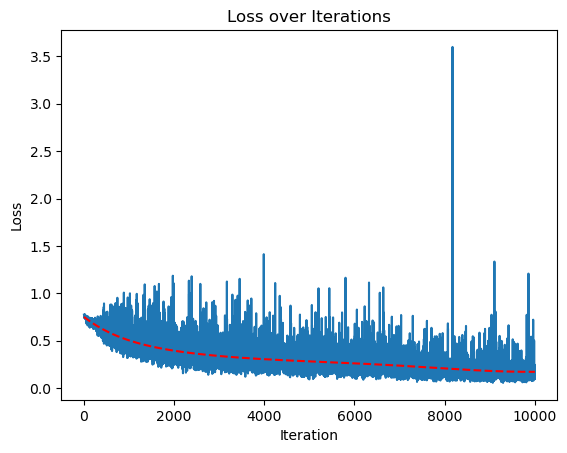

In [18]:
# Generate x-axis values from 1 to 1001
x = np.arange(1, 10002)
# Plot loss_vector
plt.plot(x, loss_vector)
# Fit a trend line
trend_line = np.polyfit(x, loss_vector, 7)
trend_line_values = np.polyval(trend_line, x)
plt.plot(x, trend_line_values, color='red', linestyle='dashed', label='Trend Line')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over Iterations')
# Display the plot
plt.show()

In [19]:
print(loss_vector[-5:-1])

[0.11512164 0.13846846 0.093559   0.10177586]


(235, 326, 3)
The shape of Prd:  torch.Size([1, 2, 256, 256])
The shape of Pred:  torch.Size([1, 2, 235, 326])


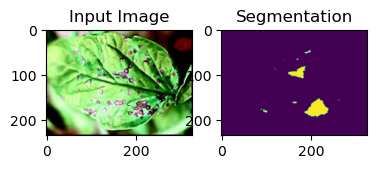

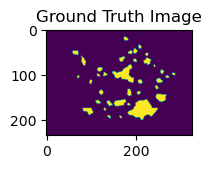

In [26]:
import torch.nn as nn
import torch.nn.functional as F
import cv2
import torch
import torchvision.transforms as tf
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import datetime
import pandas as pd

modelPath = "/kaggle/working/10000.torch"  # Path to trained model
imagePath = "/kaggle/input/leaf-disease-segmentation-dataset/data/data/images/00000.jpg"  # Test image
GTPath = "/kaggle/input/leaf-disease-segmentation-dataset/data/data/masks/00000.png" # Ground Truth
height = width = 256
# Convert 'ground_truth' to numpy array
ground_truth_seg = cv2.imread(GTPath, cv2.IMREAD_GRAYSCALE)
ground_truth_seg_np = ground_truth_seg.astype(np.uint8)

# Resize image for processing
transformImg = tf.Compose([
    tf.ToPILImage(),
    tf.Resize((height, width)),
    tf.ToTensor()
])

# Determine devices avaiable
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

net = SegNet()
net = net.to(device)  # Set net to GPU or CPU
net.load_state_dict(torch.load(modelPath))  # Load trained model from /kaggle/working
# Set to evaluation mode
net.eval()

# Load test image
Img = cv2.imread(imagePath)
height_origin, width_origin, d = Img.shape  
img = Img
print(Img.shape)

# Transform to PyTorch tensor
Img = transformImg(Img)
Img = torch.autograd.Variable(Img, requires_grad=False).to(device).unsqueeze(0)

# Run the Bayesian net
with torch.no_grad():
    Prd = net(Img)
print("The shape of Prd: ", Prd.shape)

# Resize to original size
Pred = F.interpolate(Prd, size=(height_origin, width_origin), mode='bilinear', align_corners=True)
print("The shape of Pred: ",Pred.shape)

# Convert probability to class map
seg = torch.argmax(Pred, dim=1).squeeze().cpu().detach().numpy()
# Convert 'seg' to numpy array
seg_np = seg.astype(np.uint8)

# Show images
fig = plt.figure()
fig.add_subplot(131)
plt.title("Input Image")
plt.imshow(img)


fig.add_subplot(132)
plt.title("Segmentation")
plt.imshow(seg)

# Show images
fig = plt.figure()
fig.add_subplot(133)
plt.title("Ground Truth Image")
plt.imshow(ground_truth_seg)

In [23]:
# Accuracy
# Calculate the pixel-wise accuracy
accuracy = np.mean(seg_np == ground_truth_seg_np)
# ------------------------------------------------
# Intersection over union
# Compute the intersection and union
intersection = np.logical_and(seg_np, ground_truth_seg_np)
union = np.logical_or(seg_np, ground_truth_seg_np)
# Compute the IoU
iou = np.sum(intersection) / np.sum(union)
# ------------------------------------------------
# Preciosion
# Calculate true positives (TP) 
TP = np.sum((seg_np == 1) & (ground_truth_seg_np == 38))
# Calculate false positives (FP) 
FP = np.sum((seg_np == 1) & (ground_truth_seg_np == 0))
# Calculate precision
precision = TP / (TP + FP)
# ------------------------------------------------
# Specificity
# Calculate true negatives (TN)
TN = np.sum((ground_truth_seg_np == 0) & (seg_np == 0))
# Calculate specificity
specificity = TN / (TN + FP)

# Print the specificity
print("Specificity:", specificity)
# Print the precision
print("Precision:", precision)
# Print the IoU
print("Intersection over Union (IoU):", iou)
# Print the accuracy
print("Accuracy:", accuracy)

Specificity: 0.9991030635983967
Precision: 0.9669250645994832
Intersection over Union (IoU): 0.3516917293233083
Accuracy: 0.9305573684897533


In [31]:
test_size = 10
myfiles = np.random.randint(1, 501, size=(test_size,))
myfiles = [str(num).zfill(5) for num in myfiles]
print(myImages)

myImages = [num + ".jpg" for num in myfiles]
myTruths = [num + ".png" for num in myfiles]

modelPath = "/kaggle/working/10000.torch"  # Path to trained model
imagePath = "/kaggle/input/leaf-disease-segmentation-dataset/data/data/images/"  # Test image
GTPath = "/kaggle/input/leaf-disease-segmentation-dataset/data/data/masks/" # Ground Truth

height = width = 256

# Determine devices avaiable
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
net = SegNet()
net = net.to(device)  # Set net to GPU or CPU
net.load_state_dict(torch.load(modelPath))  # Load trained model from /kaggle/working
# Set to evaluation mode
net.eval()

# Initialise lists to store metrics 
Precision = []
Specificity = []
IOU = []
Accuracy = []
    
for i in range(len(myfiles)):
    print(i)
    # Path to images
    GTFullPath = GTPath + myTruths[i]
    imageFullPath = imagePath + myImages[i]
    # Convert 'ground_truth' to numpy array
    ground_truth_seg = cv2.imread(GTFullPath, cv2.IMREAD_GRAYSCALE)
    ground_truth_seg_np = ground_truth_seg.astype(np.uint8)

    # Resize image for processing
    transformImg = tf.Compose([
        tf.ToPILImage(),
        tf.Resize((height, width)),
        tf.ToTensor()
    ])

    # Load test image
    Img = cv2.imread(imageFullPath)
    height_origin, width_origin, d = Img.shape  
    img = Img
    
    # Transform to PyTorch tensor
    Img = transformImg(Img)
    Img = torch.autograd.Variable(Img, requires_grad=False).to(device).unsqueeze(0)

    # Run the Bayesian net
    with torch.no_grad():
        Prd = net(Img)
    
    # Resize to original size
    Pred = F.interpolate(Prd, size=(height_origin, width_origin), mode='bilinear', align_corners=True)
    
    # Convert probability to class map
    seg = torch.argmax(Pred, dim=1).squeeze().cpu().detach().numpy()
    # Convert 'seg' to numpy array
    seg_np = seg.astype(np.uint8)
    
    # Accuracy
    # Calculate the pixel-wise accuracy
    accuracy = np.mean(seg_np == ground_truth_seg_np)
    # ------------------------------------------------
    # Intersection over union
    # Compute the intersection and union
    intersection = np.logical_and(seg_np, ground_truth_seg_np)
    union = np.logical_or(seg_np, ground_truth_seg_np)
    # Compute the IoU
    iou = np.sum(intersection) / np.sum(union)
    # ------------------------------------------------
    # Preciosion
    # Calculate true positives (TP) 
    TP = np.sum((seg_np == 1) & (ground_truth_seg_np == 38))
    # Calculate false positives (FP) 
    FP = np.sum((seg_np == 1) & (ground_truth_seg_np == 0))
    # Calculate precision
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0.0

    # ------------------------------------------------
    # Specificity
    # Calculate true negatives (TN)
    TN = np.sum((ground_truth_seg_np == 0) & (seg_np == 0))
    # Calculate specificity
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0.0

    # collect metrics    
    Precision.append(precision)
    Specificity.append(specificity)
    IOU.append(iou)
    Accuracy.append(accuracy)
    # Next image
    i += 1

# Create a dictionary with the lists
data = {'Precision': Precision, 'Specificity': Specificity, 'IOU': IOU, 'Accuracy' : Accuracy, 'File' : myfiles}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Save the DataFrame to an Excel file on your computer
current_date = datetime.datetime.now()
file_path = "/kaggle/working/ResultsFile"
file_path = file_path + current_date.strftime("%Y-%m-%d_%H-%M") + '.xlsx'

df.to_excel(file_path, index=False)

['00374.jpg', '00095.jpg', '00386.jpg', '00122.jpg', '00263.jpg', '00036.jpg', '00141.jpg', '00268.jpg', '00013.jpg', '00426.jpg']
0
1
2
3
4
5
6
7
8
9


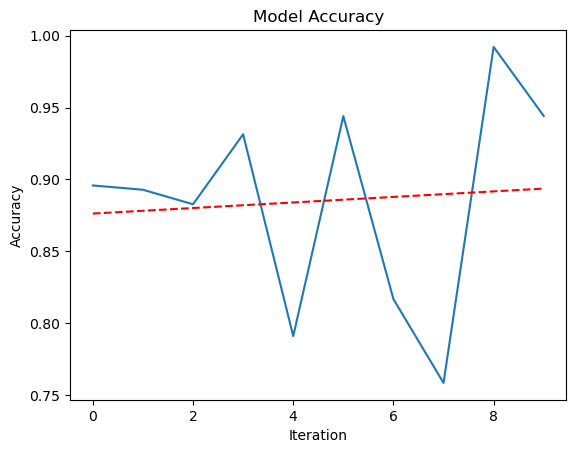

In [39]:
# Plot loss_vector
plt.plot(range(len(Accuracy)), Accuracy)
# Fit a trend line
trend_line = np.polyfit(range(len(Accuracy)), Accuracy, 1)
trend_line_values = np.polyval(trend_line, range(len(Accuracy)))
plt.plot(range(len(Accuracy)), trend_line_values, color='red', linestyle='dashed', label='Trend Line')

plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
# Display the plot
plt.show()